# With TF

In [54]:
import keras
import tensorflow as tf
import numpy as np
from keras import layers
from keras.utils import image_dataset_from_directory
from keras.applications import vgg16
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model
import matplotlib.pyplot as plt

In [55]:
def show_image(image_list, label_list= None):
    """Plot images."""
    
    fig = plt.figure(figsize=(10, 5))
    for i, file in enumerate(image_list):
        
        # if image is numpy array
        if isinstance(file, np.ndarray):
            img= file
        # if image is PIL image
        else:
            img = np.array(file)
        
        print('Image shape:', img.shape)
        ax = fig.add_subplot(2, int(len(image_list)/2), i+1)
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(img)
    
        if label_list is not None:
            ax.set_title(label_list[i])
    
    plt.tight_layout()
    plt.show()

## Load Dataset

In [56]:
train_path= 'dataset/dogs-vs-cat/train'
valid_path= 'dataset/dogs-vs-cat/valid'
test_path= 'dataset/dogs-vs-cat/test'
batch_size= 32

train_ds= image_dataset_from_directory(
    train_path,
    image_size= (224, 224),
    batch_size= 32, 
    shuffle= True,
    seed= 1,
    label_mode= 'categorical',
)
val_ds= image_dataset_from_directory(
    valid_path,
    image_size= (224, 224),
    batch_size= 32, 
    shuffle= True,
    seed= 1,
    label_mode= 'categorical',
)
test_ds= image_dataset_from_directory(
    test_path,
    image_size= (224, 224),
    batch_size= 32, 
    shuffle= True,
    seed= 1,
    label_mode= 'categorical',
)

Found 202 files belonging to 2 classes.
Found 103 files belonging to 2 classes.
Found 451 files belonging to 2 classes.


## Preprocess

In [57]:
# preprocessing
preprocessing= keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.Rescaling(scale= 1./255.),
    layers.Normalization(),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)


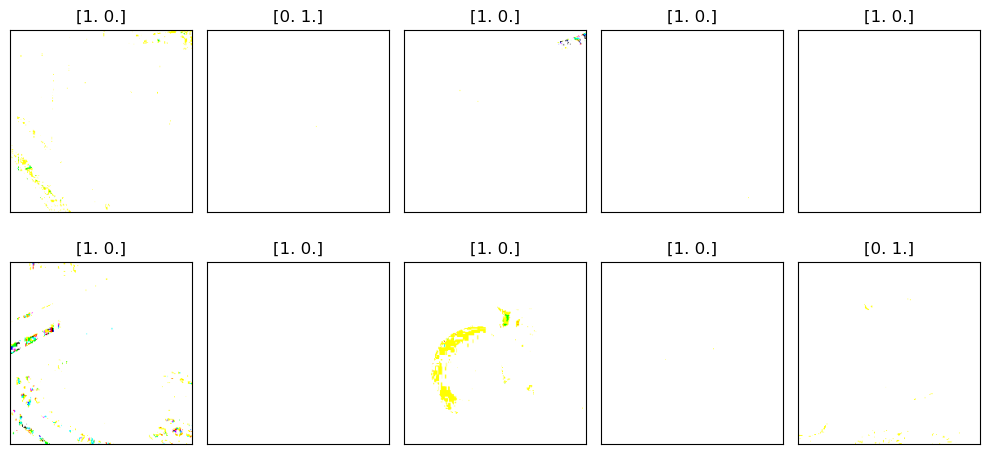

In [58]:
samples= train_ds.unbatch().take(10)
images= []
labels= []

for (image, label) in samples.as_numpy_iterator():
    images.append(image)
    labels.append(label)

show_image(images, labels)

## Create Model

In [59]:
base_model= vgg16.VGG16(include_top= False, 
                        weights= 'imagenet', 
                        input_shape= (224, 224, 3),
                        )
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [60]:
# freeze all layers
for layer in base_model.layers:
    layer.trainable= False

In [61]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [62]:
last_layer= base_model.get_layer(index= -1)
last_layer_output= last_layer.output
last_layer_output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [63]:
inputs = keras.Input(shape=(224, 224, 3))

x = preprocessing(inputs) # data augmentation

x = vgg16.preprocess_input(x) # apply input value scaling

x = base_model(x)

x= Flatten()(x)

x= Dense(64, activation= 'relu', name= 'FC_2')(x)
x= BatchNormalization()(x)
x= Dropout(0.3)(x)

x= Dense(32, activation= 'relu', name= 'FC_3')(x)
x= BatchNormalization()(x)
x= Dropout(0.3)(x)

x= Dense(16, activation= 'relu', name= 'FC_4')(x)
x= BatchNormalization()(x)
x= Dropout(0.3)(x)

outputs= Dense(2, activation= 'softmax', name= 'softmax')(x)

new_model= Model(inputs= inputs, outputs= outputs)
new_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       7         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0   

In [64]:
new_model.compile(loss= 'categorical_crossentropy', 
                  optimizer= Adam(learning_rate= 0.0001),
                  metrics= ['accuracy'])

In [65]:
epochs = 30
history = new_model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1)

Epoch 1/30


7/7 [==============================] - 38s 5s/step - loss: 1.1486 - accuracy: 0.5198 - val_loss: 0.8280 - val_accuracy: 0.5049
Epoch 2/30
7/7 [==============================] - 36s 5s/step - loss: 1.0677 - accuracy: 0.5743 - val_loss: 0.8313 - val_accuracy: 0.5049
Epoch 3/30
4/7 [================>.............] - ETA: 11s - loss: 1.0781 - accuracy: 0.5234

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc= new_model.evaluate(test_ds)
print(f'Test accuracy = {test_acc: .4f} - test loss = {test_loss: 4f}')

15/15 [==============================] - 54s 4s/step - loss: 0.9721 - accuracy: 0.4457
Test accuracy =  0.4457 - test loss =  0.972114


Test accuracy =  0.7539 - test loss =  0.655628

# With Pytorch

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import torch.nn.functional as F

from pathlib import Path
import os
from PIL import Image
import numpy as np

In [ ]:
batch_size= 8

transforms_train= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

transforms_test= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

transforms_label= transforms.Compose([
    transforms.ToTensor(),
    lambda x: F.one_hot(x, -1)
])

# train
dir_= Path('dataset/dogs-vs-cat/train')
train_set= datasets.ImageFolder(
    dir_, 
    transform= transforms_train, 
)
train_dl= DataLoader(
    train_set,
    batch_size= batch_size,
    shuffle= True
)

# validation
dir_= Path('dataset/dogs-vs-cat/valid')
val_set= datasets.ImageFolder(
    dir_, 
    transform= transforms_train,
)
val_dl= DataLoader(
    val_set, 
    batch_size= 
    batch_size, 
    shuffle= True
)

# test
dir_= Path('dataset/dogs-vs-cat/test')
test_set= datasets.ImageFolder(
    dir_, 
    transform= transforms_test,
)
test_dl= DataLoader(
    test_set, 
    batch_size= batch_size, 
    shuffle= False
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

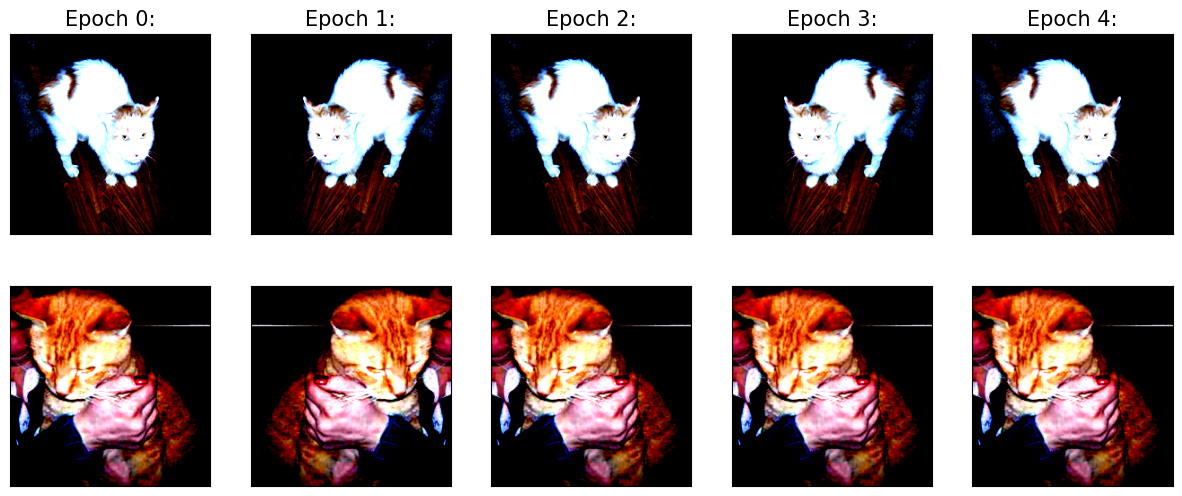

In [ ]:
batch_size = 2
augment_samples= DataLoader(train_set, batch_size= batch_size)

fig = plt.figure(figsize=(15, 6))
num_epochs = 5
for j in range(num_epochs):
    img_batch, label_batch = next(iter(augment_samples))
    
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:', size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))

In [ ]:
base_model= models.vgg16(weights='IMAGENET1K_V1')
base_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
base_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
base_model.classifier[-1].out_features

1000

In [ ]:
base_model.classifier.add_module(
    name= 'binary_clf', 
    module= nn.Linear(
        in_features= base_model.classifier[-1].out_features, 
        out_features= 2)
)

In [ ]:
base_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
  (binary_clf): Linear(in_features=1000, out_features=2, bias=True)
)

In [ ]:
loss_fn= nn.BCEWithLogitsLoss()
optimizer= torch.optim.Adam(base_model.parameters(), lr= 0.0001)

n_epochs= 1
log_print= 1

n_train_samples= len(train_dl.dataset)
n_val_samples= len(val_dl.dataset)

In [ ]:
acc_hist_train= [0] * n_epochs
acc_hist_val= [0] * n_epochs

loss_hist_train= [0] * n_epochs
loss_hist_val= [0] * n_epochs

for epoch in range(n_epochs):

    base_model.train()
    for x_batch, y_batch in train_dl:
        
        y_pred_logits= base_model(x_batch)
        # loss= loss_fn(y_pred_logits, y_pred)
        # loss.backward()
        # optimizer.step()
        # optimizer.zero_grad()
        
        # y_pred= torch.argmax(y_pred_logits, dim= 1)
        # true_pred= (y_pred == y_batch)
        
        print(y_pred_logits, y_batch)
        break

tensor([[ 0.5568, -3.8444],
        [ 0.3957, -1.7408],
        [-1.2924, -0.4383],
        [-2.6948,  0.0883],
        [-1.5215,  0.3809],
        [-0.0905, -3.8361],
        [-0.6617, -2.9819],
        [ 0.0902, -0.7697]], grad_fn=<AddmmBackward0>) tensor([1, 1, 1, 0, 1, 1, 1, 0])


In [ ]:
tensor = [
    [-1.4113, -0.0262],
    [0.3583, -1.4708],
    [-0.8076, -1.6834],
    [0.2654, -1.1023],
    [2.9400, 0.7721],
    [-0.2965, -0.9601],
    [1.5183, 0.9368],
    [-1.2978, -0.4997],
]
t = torch.Tensor(tensor)
label = torch.LongTensor([1, 0, 0, 1, 0, 1, 1, 1])
label.reshape(-1, 1)

tensor([[1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1]])